Created on January 1st 2021 by Patrick Rotzetter

https://www.linkedin.com/in/rotzetter/

# Small experiment of document mining with various techniques Part 5

This notebook will check the usage of the Azure analytics API and see how this can accelerate the overall process

## Load the files

In [1]:
# Import require libraries
import numpy as np
import texthero as hero
import pdftotext
import pandas as pd

In [2]:
# function to read PDF files using pdftotext
def readPdfFile(filename):
    text=""
    with open(filename, "rb") as f:
        pdf = pdftotext.PDF(f)
        for page in pdf:
            text=text+page
    return text

In [3]:
# function to read PPT files
def readPPTFile(filename):
    text=""  
    prs = Presentation(filename)
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                text=text+shape.text
    text=remove_special_characters(text)
    return text

In [4]:
#path of first input test file
path='./sampledocs/'

In [5]:
# let us scan the full directory, read PDF and PPT documents, clean them and process them with spacy

docName=[]
docType=[]
docText=[]
docNLP=[]
import glob
list_of_files = glob.glob(path+'*.pdf')           # create the list of file
fileNames=[]
for file_name in list_of_files:
    fileText=readPdfFile(file_name)
    docName.append(file_name)
    docType.append('pdf')
    docText.append(fileText)
list_of_files = glob.glob(path+'*.pptx')           # create the list of file
for file_name in list_of_files:
    fileText=readPPTFile(file_name)
    docName.append(file_name)
    docType.append('ppt')
    docText.append(fileText)
fullDocs = pd.DataFrame({'Name':docName,'Type':docType,'Text':docText})
fullDocs['cleanText']=hero.clean(fullDocs['Text'])
#fullDocs['NLP']=fullDocs['cleanText'].apply(processDoc)

/opt/anaconda3/envs/spacy30/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/opt/anaconda3/envs/spacy30/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


In [6]:
 print ("Average length of text:" + str((np.mean(fullDocs['Text'].str.len()))))
 print ("Min length of text:" + str((np.min(fullDocs['Text'].str.len()))))
 print ("Max length of text:" + str((np.max(fullDocs['Text'].str.len()))))

Average length of text:173026.0
Min length of text:17987
Max length of text:464271


In [7]:
fullDocs['text_word_count'] = fullDocs['Text'].apply(lambda x: len(x.strip().split()))  # word count
fullDocs['text_unique_words']=fullDocs['Text'].apply(lambda x:len(set(str(x).split())))  # number of unique words
fullDocs.head()

,Name,Type,Text,cleanText,text_word_count,text_unique_words
0,./sampledocs/ai-360-research.pdf,pdf,AI 360: insights from the\nnext frontier of bu...,ai insights next frontier business corner offi...,5289,1752
1,./sampledocs/Module-1-Lecture-Slides.pdf,pdf,"Application of AI, Insurtech and Real Estate\n...",application ai insurtech real estate technolog...,3732,1509
2,./sampledocs/Technology-and-innovation-in-the-...,pdf,Technology and\ninnovation in the\ninsurance s...,technology innovation insurance sector technol...,16763,4237
3,./sampledocs/sigma-5-2020-en.pdf,pdf,No 5 /2020\n\n\n\n\n...,machine intelligence executive summary machine...,14512,4342
4,./sampledocs/_content_dam_Deloitte_de_Document...,pdf,From mystery to mastery:\nUnlocking the busine...,mystery mastery unlocking business value artif...,11032,3457


In [8]:
fullDocs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               10 non-null     object
 1   Type               10 non-null     object
 2   Text               10 non-null     object
 3   cleanText          10 non-null     object
 4   text_word_count    10 non-null     int64 
 5   text_unique_words  10 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 608.0+ bytes


In [9]:
fullDocs.describe()

,text_word_count,text_unique_words
count,10.000000,10.000000
mean,17238.100000,4083.700000
std,14729.007181,2398.566797
min,2502.000000,1006.000000
25%,6724.750000,2178.250000
50%,14951.000000,3961.000000
75%,18329.000000,5075.500000
max,49779.000000,8462.000000


## Azure analytics
### you can skip this part and go straight to next section if you do not want to run the text analytics on Azure but use previously stored results

In [10]:
# import required Azure libraries
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient

In [ ]:
#just a quick check that everything is working correctly

credential = AzureKeyCredential("xxxxxxxxxxxxxxxxxxxxxx") # put your own access key
endpoint="https://nlexperiments.cognitiveservices.azure.com/" # put your access keypoint

text_analytics_client = TextAnalyticsClient(endpoint, credential)

documents = [
    "I did not like the restaurant. The food was too spicy.",
    "The restaurant was decorated beautifully. The atmosphere was unlike any other restaurant I've been to.",
    "The food was yummy. :)"
]

response = text_analytics_client.analyze_sentiment(documents, language="en")
result = [doc for doc in response if not doc.is_error]

for doc in result:
    print("Overall sentiment: {}".format(doc.sentiment))
    print("Scores: positive={}; neutral={}; negative={} \n".format(
        doc.confidence_scores.positive,
        doc.confidence_scores.neutral,
        doc.confidence_scores.negative,
    ))

In [12]:
documents=list(fullDocs.Text)

In [13]:
def split_to_sentences(data):
    """
    Split data by linebreak "\n"
    
    Args:
        data: str
    
    Returns:
        A list of sentences
    """
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    sentences = data.split("\n")
    ### END CODE HERE ###
    
    # Additional clearning (This part is already implemented)
    # - Remove leading and trailing spaces from each sentence
    # - Drop sentences if they are empty strings.
    sentences = [s.strip() for s in sentences]
    sentences = [s for s in sentences if len(s) > 0]
    
    return sentences  

In [14]:
#split all documents in sentences to process in Azure Analytics later on
listofdocumentsentences=[]
for doc in documents:
    sentences=split_to_sentences(doc)
    listofsentences=[]
    for sent in sentences:
        if len(sent) > 5120:
            print('max limit reached')
        else:
            listofsentences.append(sent)
    listofdocumentsentences.append(listofsentences)


In [15]:
# use a generator to return list of 5 sentences to use with Azure Analytics
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [36]:
entityList=[]
for listofsentences in listofdocumentsentences:
    entPerDoc=[]
    for c in chunks(listofsentences,5):
        try:
            response = text_analytics_client.recognize_entities(c, language="en")
            result = [doc for doc in response if not doc.is_error]
            for doc in result:
                for entity in doc.entities:
                    entPerDoc.append(entity)
        except Exception as err:
            print("Encountered exception. {}".format(err))
    entityList.append(entPerDoc)

In [53]:
#let us save the result in a file for later use
import pickle 
filename='./results'
filehandler = open(filename, 'wb') 
pickle.dump(entityList,filehandler)

## Use previously stored results

In [16]:
# import required Azure libraries
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient

In [17]:
#let us load the results from previous save
import pickle 
filename='./results'
filehandler = open(filename, 'rb') 
entityList=pickle.load(filehandler)

In [18]:
len(entityList)

10

In [19]:
# let us look most used words for each entity category
from collections import defaultdict, Counter

posCounts = defaultdict(Counter)

for doc in entityList:
    for entity in doc:
        posCounts[entity.category][entity.text] += 1

for pos_id, counts in sorted(posCounts.items()):
    #print(pos_id, counts)
    for orth_id, count in counts.most_common(1):
        print(pos_id,orth_id, count)

Address 41 University Drive, Suite 202 1
DateTime may 144
Email institute@swissre.com 2
Event interviews 19
Location US 71
Organization EU 177
Person Digitalisation 11
PersonType customer 393
Phone Number 41 43 285 2551 4
Product cars 26
Quantity 1 223
Skill AI 1109
URL axco.co.uk 4


In [20]:
# most frequest organization
entities=[]
for doc in entityList:
    for entity in doc:
        if entity.category == 'Organization':
                entities += [entity.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
print(commonEntities)

[('EU', 177), ('AI', 140), ('MI', 77), ('Swiss Re Institute', 59), ('FRA', 50), ('IAIS Executive Committee', 36), ('GDPR', 33), ('European Commission', 28), ('McKinsey', 27), ('European Parliament', 26), ('OECD', 24), ('Digital', 20), ('FCA', 19), ('Facebook', 18), ('BIMA', 16), ('Google', 15), ('InsurTech', 15), ('Uber', 15), ('IAIS', 15), ('European Union', 14), ('European Council', 13), ('P&C', 13), ('FinTech', 12), ('MAS', 12), ('Gartner', 12), ('Swiss Re', 12), ('Amazon', 11), ('Council of Europe', 10), ('EU Member States', 10), ('Alibaba', 9), ('Milken Institute', 9), ('Accenture', 9), ('Lemonade', 9), ('ASIC', 9), ('PCW', 9), ('PCWs', 9), ('Commission', 9), ('Luxembourg, Publications Office', 9), ('Allianz', 8), ('Netflix', 8)]


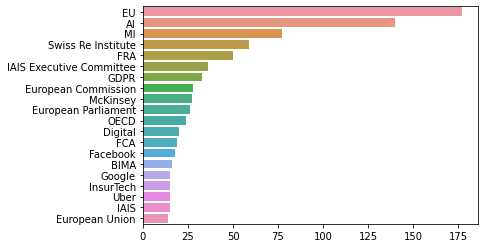

In [25]:
import seaborn as sns

def displayEntitiesChart(commonEntities,n=20):
    x, y= [], []
    for word,count in commonEntities[:n]:
            x.append(word)
            y.append(count)
        
    sns.barplot(x=y,y=x)
displayEntitiesChart(commonEntities)

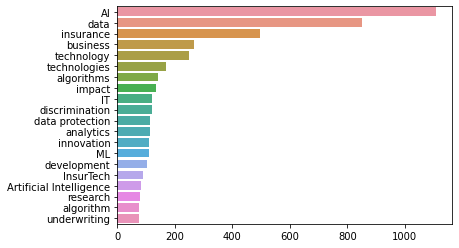

In [26]:
# most frequest skills
entities=[]
for doc in entityList:
    for entity in doc:
        if entity.category == 'Skill':
                entities += [entity.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
displayEntitiesChart(commonEntities)

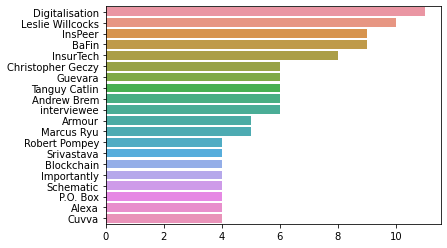

In [27]:
# most frequest skills
entities=[]
for doc in entityList:
    for entity in doc:
        if entity.category == 'Person':
                entities += [entity.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
displayEntitiesChart(commonEntities)

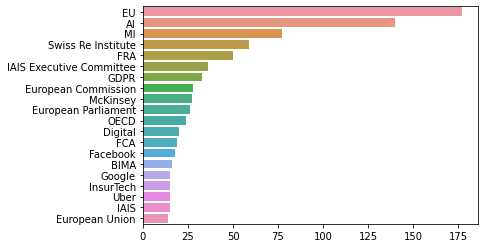

In [28]:
# most frequest skills
entities=[]
for doc in entityList:
    for entity in doc:
        if entity.category == 'Organization':
                entities += [entity.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
displayEntitiesChart(commonEntities)